In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

In [2]:
dataframe = pd.read_csv("MobilePriceDataset.csv")
dataframe.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
dataframe['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

In [4]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1235)
train_dataframe = dataframe.drop(val_dataframe.index)

print('Validation Dataframe Shape:', val_dataframe.shape)
print('Train Dataframe Shape:', train_dataframe.shape)

Validation Dataframe Shape: (400, 21)
Train Dataframe Shape: (1600, 21)


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("price_range")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [6]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [7]:
def encode_numerical_feature(feature, name, dataset):
    
    normalizer = Normalization()
    
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

In [8]:
def encode_categorical_feature(feature, name, dataset, is_string):
    
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)

    encoded_feature = lookup(feature)
    return encoded_feature

In [9]:
categorical_columns = ["blue","dual_sim","fc","four_g","n_cores","pc","three_g","touch_screen","wifi"]
numerical_columns  = ["battery_power","clock_speed","int_memory","m_dep","mobile_wt","px_height","px_width","ram","sc_h","sc_w","talk_time"]

In [10]:
def input_Model(features, dtype):
    inputs = list()
    
    for feature in features:
        i = keras.Input(shape=(1,), name=feature, dtype=dtype)
        inputs.append(i)
    
    return inputs

In [11]:
categorical_inputs = input_Model(categorical_columns, "int64")  
numerical_inputs = input_Model(numerical_columns, "int64")

In [12]:
def features_Model(features, name, dataset, encode, is_string=None):
    inputs = list()
    if encode == 'numerical':
        for index, feature in enumerate(features):
            inputs.append(encode_numerical_feature(feature, name[index], dataset))
    elif encode == 'categorical':
        for index, feature in enumerate(features):
            inputs.append(encode_categorical_feature(feature, name[index], dataset, is_string))
    
    return inputs

In [13]:
categorical_features = features_Model(categorical_inputs, categorical_columns, train_ds, 'categorical', False)
numerical_features =  features_Model(numerical_inputs, numerical_columns, train_ds, 'numerical')

In [14]:
categorical_inputs.extend(numerical_inputs)
all_inputs = categorical_inputs.copy()    

In [15]:
categorical_features.extend(numerical_features)
all_features = categorical_features.copy()   
all_features = layers.concatenate(all_features)

In [16]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
output = layers.Dense(4, activation="softmax")(x)
model = keras.Model(all_inputs, output)

In [17]:
model.compile("adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

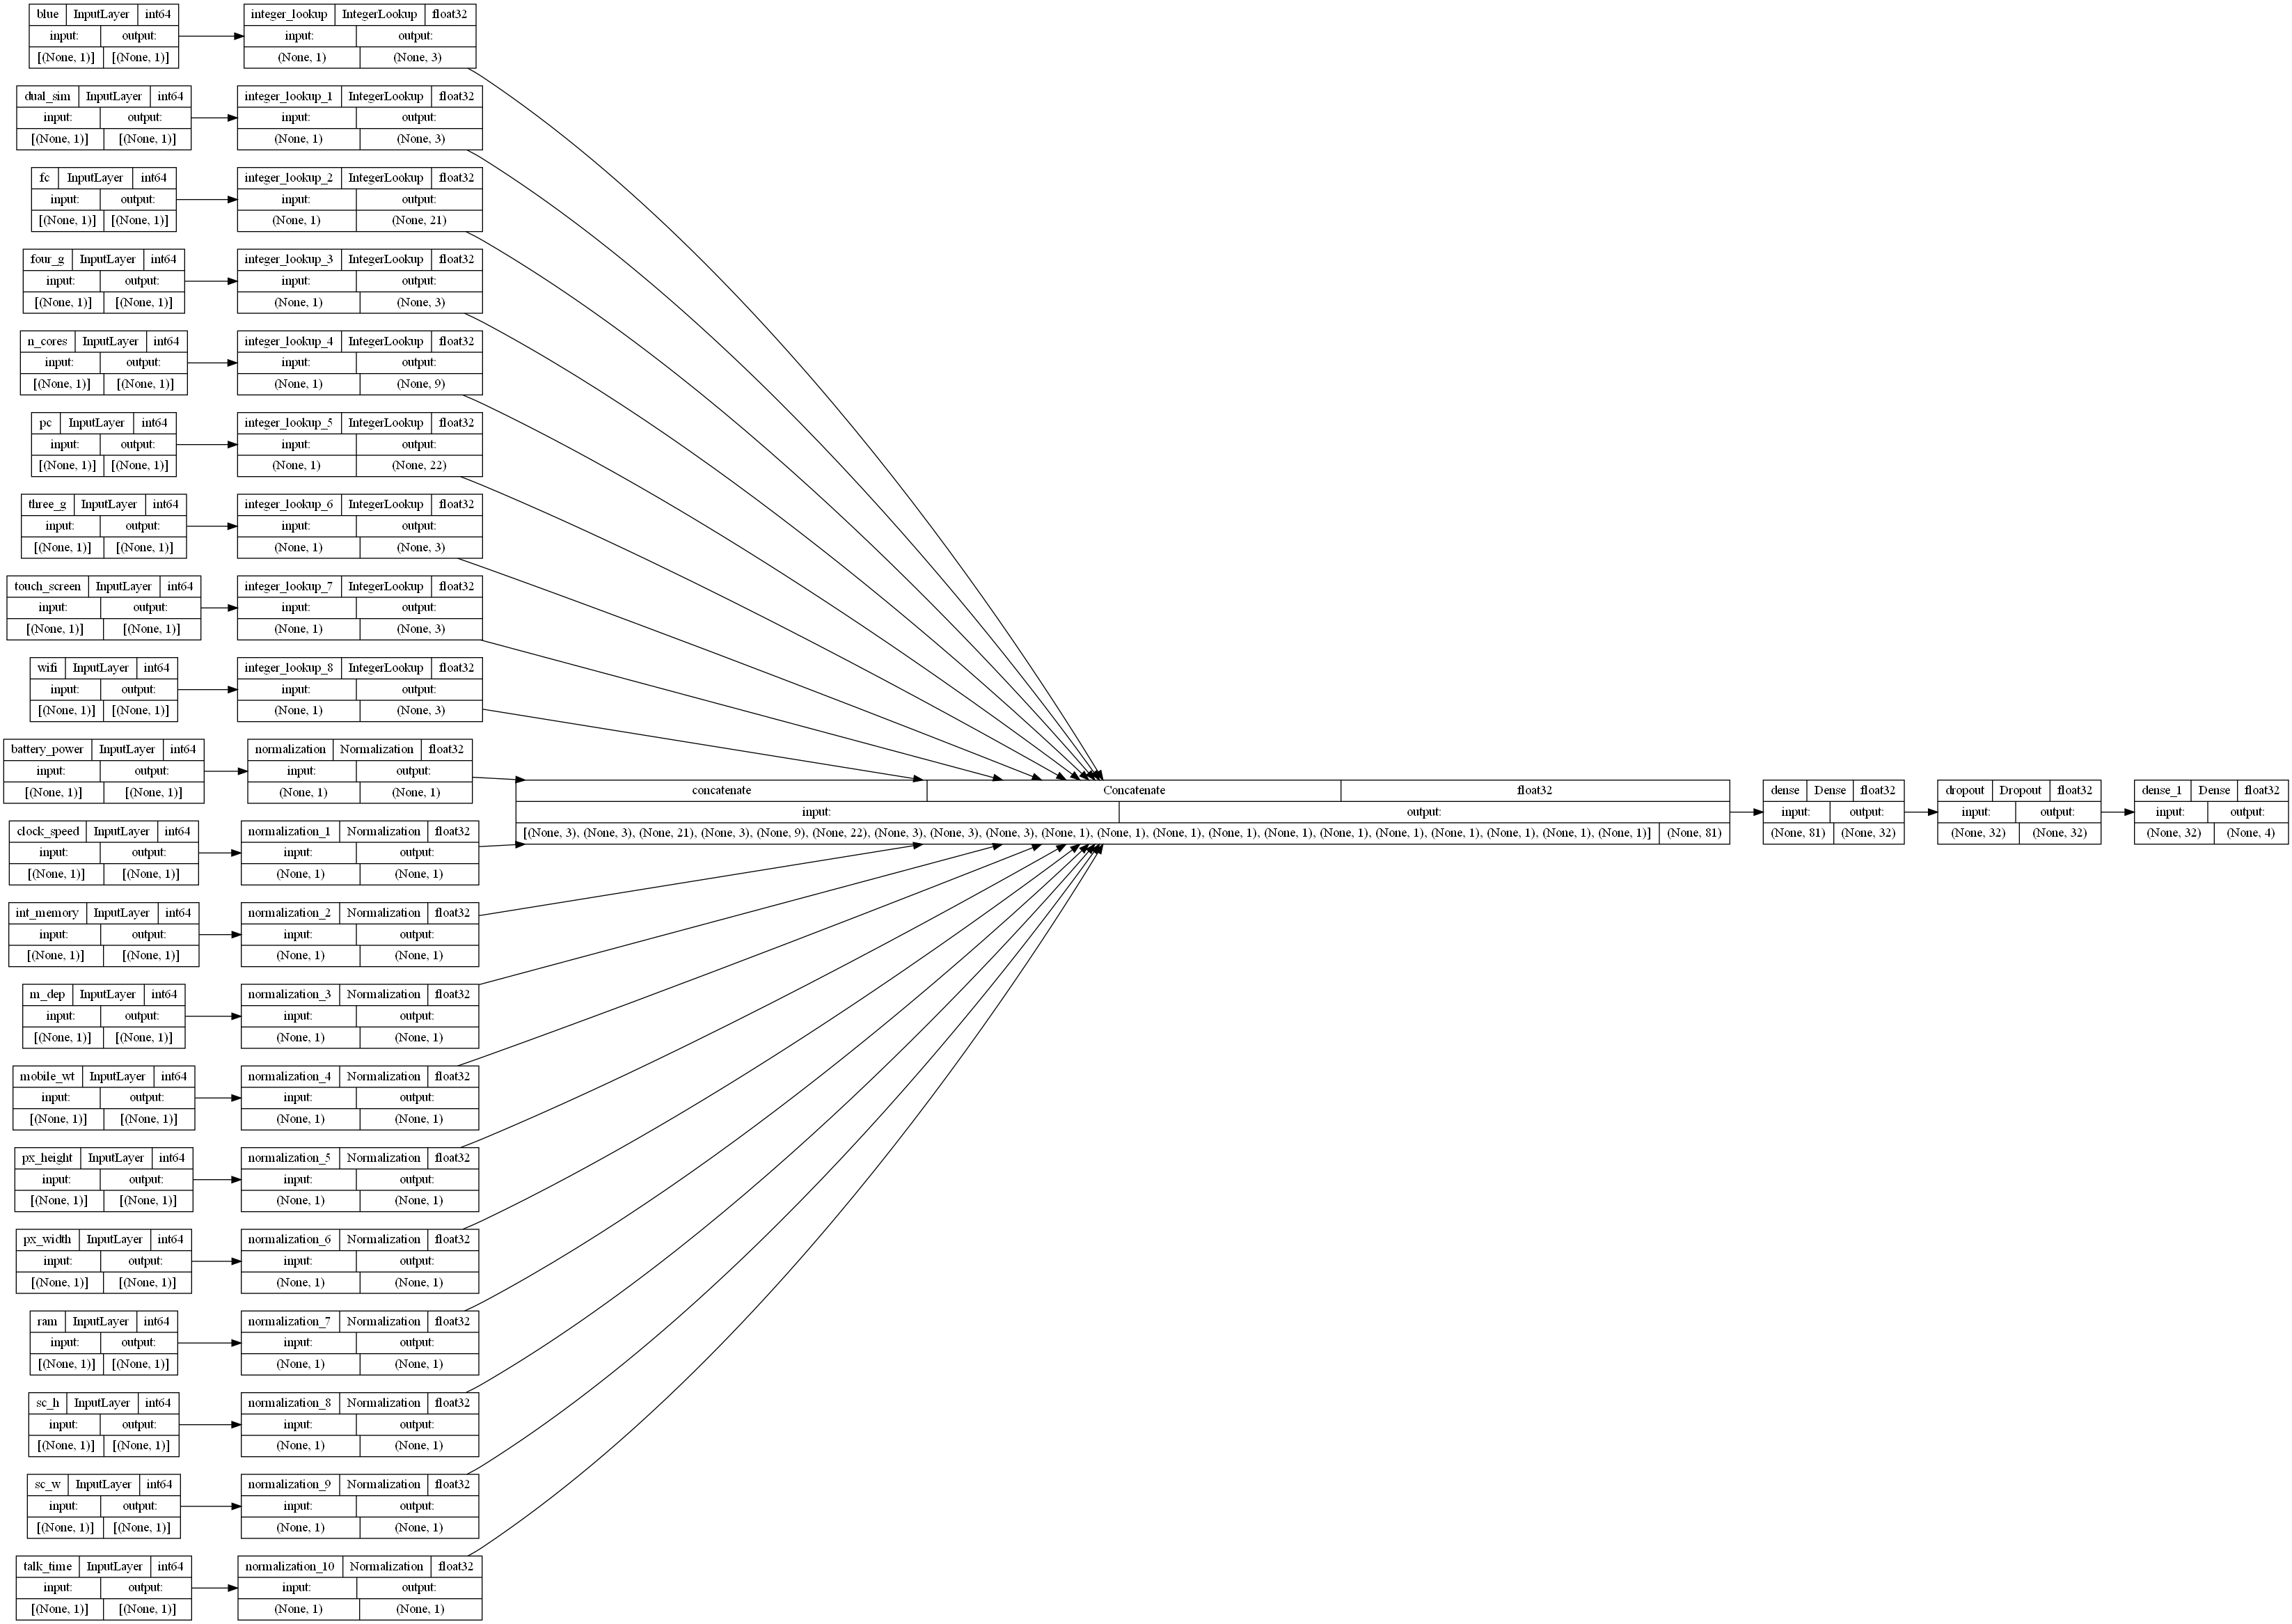

In [18]:
#model.summary()
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, rankdir="LR")

In [19]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
50/50 [==============================] - 2s 17ms/step - loss: 1.4113 - accuracy: 0.2956 - val_loss: 1.3188 - val_accuracy: 0.3900
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 1.2463 - accuracy: 0.4500 - val_loss: 1.2070 - val_accuracy: 0.4825
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 1.1087 - accuracy: 0.5500 - val_loss: 1.0867 - val_accuracy: 0.5550
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.9978 - accuracy: 0.5950 - val_loss: 0.9653 - val_accuracy: 0.6375
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.8823 - accuracy: 0.6438 - val_loss: 0.8600 - val_accuracy: 0.6650
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.8010 - accuracy: 0.6737 - val_loss: 0.7739 - val_accuracy: 0.7275
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.7121 - accuracy: 0.7475 - val_loss: 0.7046 - val_accuracy: 0.7675
Epoch 8/50
50/50 [=

In [20]:
sample = {
    "battery_power":1846,
    "blue":1,
    "clock_speed":1,
    "dual_sim":0,
    "fc":5,
    "four_g":1,
    "int_memory":53,
    "m_dep":0.7,
    "mobile_wt":106,
    "n_cores":8,
    "pc":7,
    "px_height":185,
    "px_width":1832,
    "ram":563,
    "sc_h":9,
    "sc_w":5,
    "talk_time":10,
    "three_g":1,
    "touch_screen":0,
    "wifi":1,   
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(predictions)

1/1 [==============================] - 0s 440ms/step
[[7.3379862e-01 2.6617414e-01 2.7300906e-05 5.9466527e-13]]


In [21]:
price_range = list(predictions[0]).index(max(predictions[0]))

print('{}.Price Range was predicted with {:.2f}% probability.'.format(price_range, max(predictions[0])))

0.Price Range was predicted with 0.73% probability.


## Source

https://keras.io/examples/structured_data/structured_data_classification_from_scratch/